In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

In [2]:
image_path = "../data"
celeba_dataset = torchvision.datasets.CelebA(image_path, split='train', target_type='attr', download=False)
assert isinstance(celeba_dataset, torch.utils.data.Dataset)

In [4]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [21]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    def __init__(self, source_dataset, transform=None):
        super().__init__()
        self.source_dataset = source_dataset
        self.transform = transform
    
    def __getitem__(self, index):
        img, lbl = self.source_dataset[index]
        if self.transform is not None:
            img = self.transform(img)

        return img, lbl[20]

    def __len__(self):
        return len(self.source_dataset)

In [6]:
list(enumerate(celeba_dataset.attr_names))

[(0, '5_o_Clock_Shadow'),
 (1, 'Arched_Eyebrows'),
 (2, 'Attractive'),
 (3, 'Bags_Under_Eyes'),
 (4, 'Bald'),
 (5, 'Bangs'),
 (6, 'Big_Lips'),
 (7, 'Big_Nose'),
 (8, 'Black_Hair'),
 (9, 'Blond_Hair'),
 (10, 'Blurry'),
 (11, 'Brown_Hair'),
 (12, 'Bushy_Eyebrows'),
 (13, 'Chubby'),
 (14, 'Double_Chin'),
 (15, 'Eyeglasses'),
 (16, 'Goatee'),
 (17, 'Gray_Hair'),
 (18, 'Heavy_Makeup'),
 (19, 'High_Cheekbones'),
 (20, 'Male'),
 (21, 'Mouth_Slightly_Open'),
 (22, 'Mustache'),
 (23, 'Narrow_Eyes'),
 (24, 'No_Beard'),
 (25, 'Oval_Face'),
 (26, 'Pale_Skin'),
 (27, 'Pointy_Nose'),
 (28, 'Receding_Hairline'),
 (29, 'Rosy_Cheeks'),
 (30, 'Sideburns'),
 (31, 'Smiling'),
 (32, 'Straight_Hair'),
 (33, 'Wavy_Hair'),
 (34, 'Wearing_Earrings'),
 (35, 'Wearing_Hat'),
 (36, 'Wearing_Lipstick'),
 (37, 'Wearing_Necklace'),
 (38, 'Wearing_Necktie'),
 (39, 'Young'),
 (40, '')]

In [12]:
male_indices = [i for i in range(len(celeba_dataset)) if celeba_dataset.attr[i, 20] == 1 and celeba_dataset.attr[i, 15] == 0]
female_indices = [i for i in range(len(celeba_dataset)) if celeba_dataset.attr[i, 20] == 0 and celeba_dataset.attr[i, 15] == 0]
len(male_indices), len(female_indices)

(59895, 92354)

In [13]:
import random
random.shuffle(male_indices)
random.shuffle(female_indices)

In [16]:
from torch.utils.data import Subset
train_indices = male_indices[:1000] + female_indices[:1000]
random.shuffle(train_indices)
train_set_raw = Subset(celeba_dataset, train_indices)

valid_indices = male_indices[1000:2000] + female_indices[1000:2000]
random.shuffle(valid_indices)
valid_set_raw = Subset(celeba_dataset, valid_indices)

test_indices = male_indices[2000:3000] + female_indices[2000:3000]
random.shuffle(test_indices)
test_set_raw = Subset(celeba_dataset, test_indices)

In [39]:
from torch.utils.data import DataLoader
train_set = ImageDataset(train_set_raw, transform)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4)

valid_set = ImageDataset(valid_set_raw, transform)
valid_loader = DataLoader(valid_set, batch_size=16, num_workers=4)

In [63]:
import torch.nn as nn
import torch.nn.functional as F

# class Model(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.fc1 = nn.Linear(input_size, 512)
#         self.fc2 = nn.Linear(512, 128)
#         self.fc3 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 128 -> 64
        x = self.pool(F.relu(self.conv2(x))) # 64 -> 32
        x = self.pool(F.relu(self.conv3(x))) # 32 -> 16
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# input_size = 128*128
# model = Model(input_size).to(device)
model = Model().to(device)

lr = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 10
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
val_loss_hist = [0] * num_epochs
val_accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        
    
    with torch.no_grad():
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            loss_hist[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist[epoch] += is_correct.sum().item()

        for x_batch, y_batch in valid_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            val_loss_hist[epoch] += loss.item() * y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            val_accuracy_hist[epoch] += is_correct.sum().item()

    loss_hist[epoch] /= len(train_loader.dataset)
    accuracy_hist[epoch] /= len(train_loader.dataset)
    val_loss_hist[epoch] /= len(valid_loader.dataset)
    val_accuracy_hist[epoch] /= len(valid_loader.dataset)
    print(f'Epoch {epoch}, Train loss: {loss_hist[epoch]}, Train accuracy: {accuracy_hist[epoch]}, Valid loss: {val_loss_hist[epoch]}, Valid accuracy: {val_accuracy_hist[epoch]}')

Epoch 0, Train loss: 0.490956841468811, Train accuracy: 0.777, Valid loss: 0.5132963006496429, Valid accuracy: 0.756
Epoch 1, Train loss: 0.39588954907655716, Train accuracy: 0.801, Valid loss: 0.4560957803726196, Valid accuracy: 0.78
Epoch 2, Train loss: 0.20260274118185043, Train accuracy: 0.9345, Valid loss: 0.2905902717411518, Valid accuracy: 0.8825
Epoch 3, Train loss: 0.1975086787045002, Train accuracy: 0.92, Valid loss: 0.301427213460207, Valid accuracy: 0.8785
Epoch 4, Train loss: 0.12736960431933403, Train accuracy: 0.9575, Valid loss: 0.24528549812734127, Valid accuracy: 0.902
Epoch 5, Train loss: 0.11444338951259851, Train accuracy: 0.9555, Valid loss: 0.26047534921765325, Valid accuracy: 0.9005
Epoch 6, Train loss: 0.073920868717134, Train accuracy: 0.974, Valid loss: 0.2636189236454666, Valid accuracy: 0.9015
Epoch 7, Train loss: 0.05428995654918253, Train accuracy: 0.9865, Valid loss: 0.24439447350241245, Valid accuracy: 0.9095
Epoch 8, Train loss: 0.03733075340278447, Tr

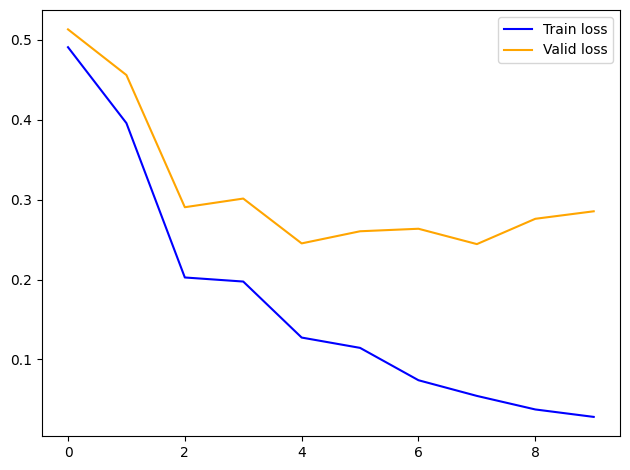

In [71]:
plt.plot(range(num_epochs), loss_hist, c='blue', label='Train loss')
plt.plot(range(num_epochs), val_loss_hist, c='orange', label='Valid loss')
plt.tight_layout()
plt.legend()
plt.show()

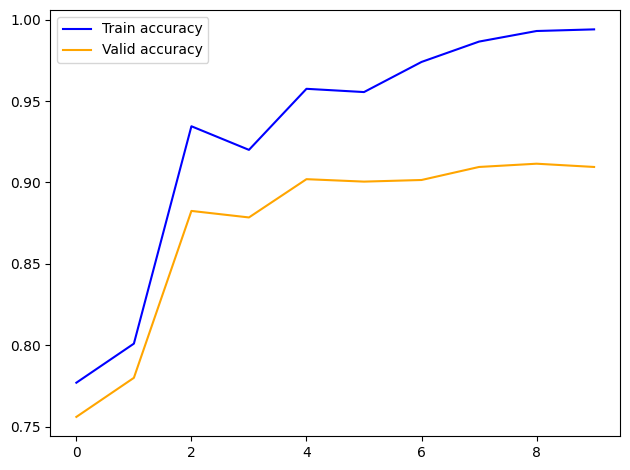

In [72]:
# accuracy_hist = [x.cpu() for x in accuracy_hist]
# val_accuracy_hist = [x.cpu() for x in val_accuracy_hist]
plt.plot(range(num_epochs), accuracy_hist, c='blue', label='Train accuracy')
plt.plot(range(num_epochs), val_accuracy_hist, c='orange', label='Valid accuracy')
plt.tight_layout()
plt.legend()
plt.show()